In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from torchvision import transforms

from models import FarSegNet
import tester
import utils
import loss
import data_loader

In [55]:
# root_path = 'D://Data/massachusetts-roads-dataset/'
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select3_parts_16/"
DIR_CHECKPOINT = 'checkpoints/'
TEST_SAVE_PATH = '/home/renyan/road-extraction/predict_result/'
FOCAL_Z = 1
FOCAL_FACTOR = 2

In [11]:
INPUT_SIZE, OUTPUT_SIZE = 256, 256
test_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, data_class = 'test')

test dataset set: 784 pairs


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FarSegNet.FarSegNet().to(device)
net.eval();
# net.load_state_dict(torch.load("checkpoints/re_farseg_epoch14_global_step24696.pth"))

In [36]:
tt_farseg = tester.Tester(net = net, 
                   device = device, 
                   dir_stat = 're_farseg_epoch33_global_step58212.pth', 
                   test_dataset = test_dataset,
                   threshold = 0.5,
                   save_path = TEST_SAVE_PATH, 
                   dir_checkpoint = DIR_CHECKPOINT)

Tester with net para in re_farseg_epoch33_global_step58212.pth is ready 
(threshold = 0.5, 784 pairs in test dataset)


In [37]:
img = cv2.imread(road_path + "test/24478855_15_h1_w4.tiff")
lbl = cv2.imread(road_path + "test_labels/24478855_15_h1_w4.tif")

In [41]:
transform_data = transforms.Compose([transforms.Resize([INPUT_SIZE, INPUT_SIZE], 0), transforms.ToTensor(),])
transform_label = transforms.Compose([transforms.Resize([OUTPUT_SIZE, OUTPUT_SIZE], 0), transforms.ToTensor(),])
img_tensor, lbl_tensor = transform_data(Image.fromarray(img)).unsqueeze(0), transform_label(Image.fromarray(lbl))[:1,:,:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor, lbl_tensor = img_tensor.to(device), lbl_tensor.to(device)

In [42]:
probs, preds = net(img_tensor)

In [46]:
a = torch.tensor([[1, 2], [3, 4]])
a.flatten()

tensor([1, 2, 3, 4])

In [51]:
p = ((1-lbl_tensor) + (-1)**(1+lbl_tensor)*probs)

In [52]:
p.shape

torch.Size([1, 1, 256, 256])

In [45]:
preds.shape

torch.Size([1, 1, 256, 256])

In [56]:
z = torch.pow(1.0 - p, FOCAL_FACTOR)
z = FOCAL_Z * z

In [58]:
z.shape

torch.Size([1, 1, 256, 256])

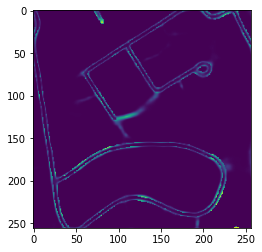

In [62]:
# 难易程度
plt.imshow(z.squeeze().cpu().detach().numpy())

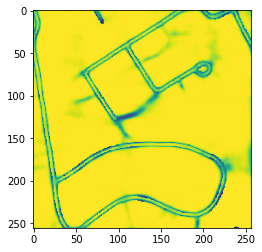

In [66]:
# 对该像素点预测的把握程度
plt.imshow(p.squeeze().cpu().detach().numpy())

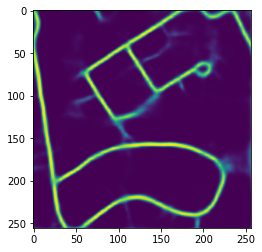

In [67]:
# 该像素点是道路的概率
plt.imshow(probs.squeeze().cpu().detach().numpy())

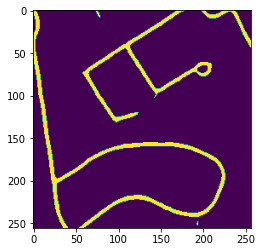

In [68]:
# 预测结果
plt.imshow(preds.squeeze().cpu().detach().numpy())